In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [2]:
df = pd.read_csv('../data/yield_final.csv')

In [3]:
categorical = ['country','crop', 'year']
numerical = ['average_rain_fall_mm_per_year',
 'pesticide_tonnes',
 'avg_temp']

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [5]:
df_train=df_train.reset_index(drop=True)
df_test=df_test.reset_index(drop=True)
df_val=df_val.reset_index(drop=True)

y_train = df_train.yield_hg_ha.values
y_test = df_test.yield_hg_ha.values
y_val = df_val.yield_hg_ha.values

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

del df_train['yield_hg_ha']
del df_test['yield_hg_ha']
del df_val['yield_hg_ha']

# Linear Regression

In [6]:
# Log-transform highly skewed numerical features
skewed_features = ['pesticide_tonnes', 'average_rain_fall_mm_per_year']
for col in skewed_features:
    df_train[col] = np.log1p(df_train[col])
    df_val[col] = np.log1p(df_val[col])
    df_test[col] = np.log1p(df_test[col])

In [7]:
scaler = StandardScaler()
df_train[numerical] = scaler.fit_transform(df_train[numerical])
df_val[numerical] = scaler.transform(df_val[numerical])
df_test[numerical] = scaler.transform(df_test[numerical])


In [8]:
def train(df_train, y_train):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    #feature_names = dv.get_feature_names_out()
    
    #print(feature_names)
    
    model = LinearRegression()
    model.fit(X_train, y_train)

    return dv, model


def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict(X)

    return y_pred

def regression_metrics(y_actual, y_pred):
    mse = mean_squared_error(y_actual, y_pred)  # compare with y_val in original units
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_actual, y_pred)
    r2 = r2_score(y_actual, y_pred)

    return rmse, mae, r2

## Results

In [9]:
# Train the model
dv, model = train(df_train, y_train_log)

# Predict on validation/test set
y_pred_val_log = predict(df_val, dv, model)  # predictions in log scale
y_pred_val = np.expm1(y_pred_val_log)        # convert back to original units

y_pred_test_log = predict(df_test, dv, model)
y_pred_test = np.expm1(y_pred_test_log)

# Evaluate on validation set (original units)
rmse, mae, r2 = regression_metrics(y_val, y_pred_val)

print("Validation RMSE:", rmse)
print("MAE:", mae)
print("Validation R2:", r2)

Validation RMSE: 37364.657196581524
MAE: 21836.710189452457
Validation R2: 0.7867100068473064


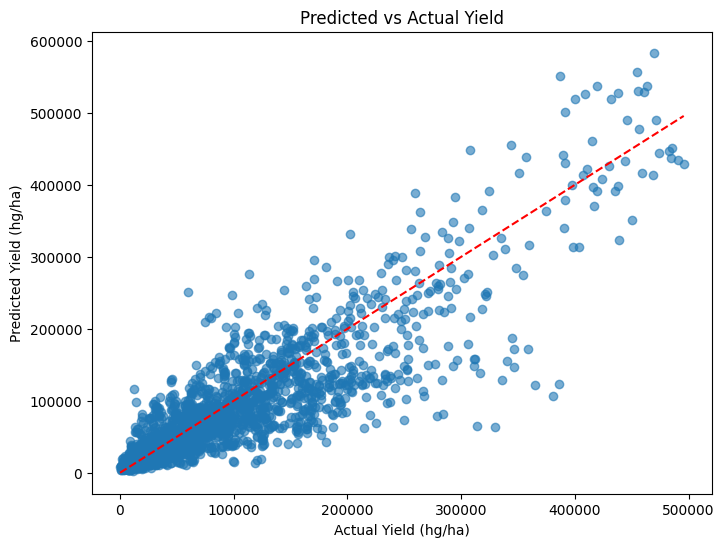

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred_val, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # perfect prediction line
plt.xlabel("Actual Yield (hg/ha)")
plt.ylabel("Predicted Yield (hg/ha)")
plt.title("Predicted vs Actual Yield")
plt.show()

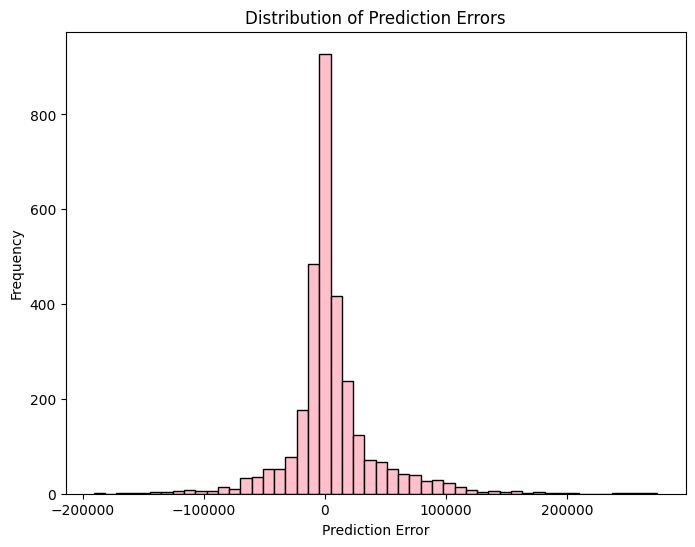

In [11]:
plt.figure(figsize=(8,6))
plt.hist(y_val - y_pred_val, bins=50, color='pink', edgecolor='k')
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()


# Random Forest

In [12]:
# Train Random Forest Regressor
def rf_train(df_train, y_train, n_estimators, max_depth, min_samples_leaf=5):
    dicts = df_train.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    rf = RandomForestRegressor(n_estimators=n_estimators, 
                               max_depth=max_depth, min_samples_leaf=min_samples_leaf, 
                               random_state=1)
    rf.fit(X_train, y_train)
    
    return dv, rf

# Predict function
def rf_predict(df, dv, rf):
    dicts = df.to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = rf.predict(X)
    return y_pred

In [13]:
# Train on log-transformed target

# Find best n_estimator and max_depth combination

n_estimators = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,100,200]

scores = [] 

for d in range(5,31,5):
    for n in n_estimators:
        dv, rf = rf_train(df_train, y_train_log, n_estimators=n, max_depth=d)
        
        # Predict on validation set
        y_pred_val_log = rf_predict(df_val, dv, rf)
        y_pred_val = np.expm1(y_pred_val_log)  # convert back to original units
        
        # Predict on test set
        y_pred_test_log = rf_predict(df_test, dv, rf)
        y_pred_test = np.expm1(y_pred_test_log)

        # Predict on train set - only to measure against val set. 
        y_pred_train_log = rf_predict(df_train, dv, rf)
        y_pred_train = np.expm1(y_pred_train_log)
        
        # Evaluate metrics on val
        rmse, mae, r2_val = regression_metrics(y_val, y_pred_val)
        
        r2_train = r2_score(y_train, y_pred_train)
        
        scores.append((d,n,rmse,mae,r2_val,r2_train))
    


In [14]:
columns = ['max_depth', 'n_estimators', 'rmse', 'mae', 'r2_val', 'r2_train']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores_pivot = df_scores.pivot(index='max_depth', columns=['n_estimators'], values=['r2_val'])

df_scores['r2_diff'] = df_scores['r2_train'] - df_scores['r2_val']


## Hyperparameter Tuning

### Choosing the best `max_depth` value

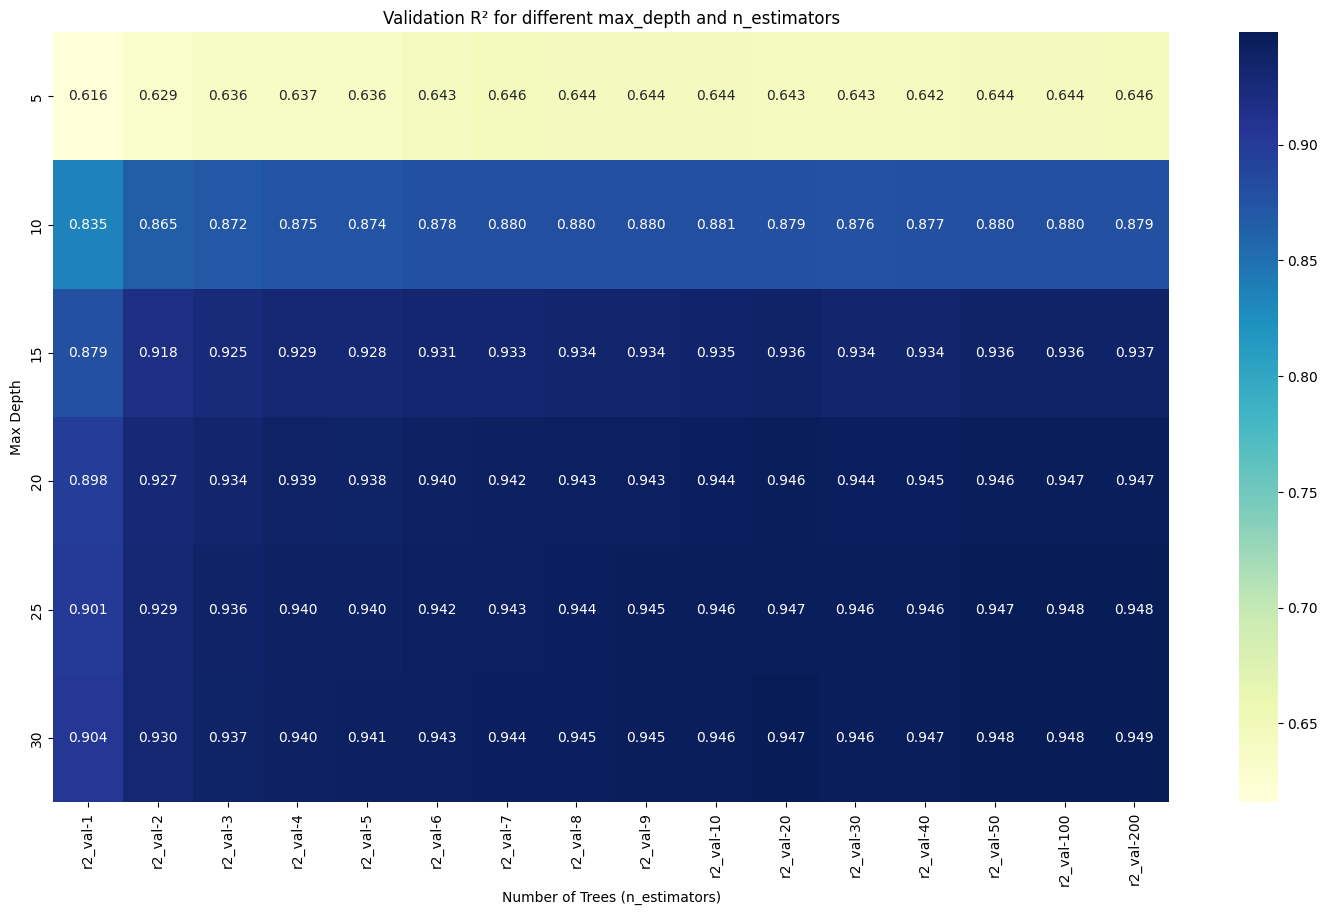

In [15]:
plt.figure(figsize=(18,10))
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f", cmap='YlGnBu')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Max Depth")
plt.title("Validation R² for different max_depth and n_estimators")
plt.show()

**Since, there's not a lot of difference in R2 values on increasing max_depth to more than 20, we will stick with `max_depth=20`**

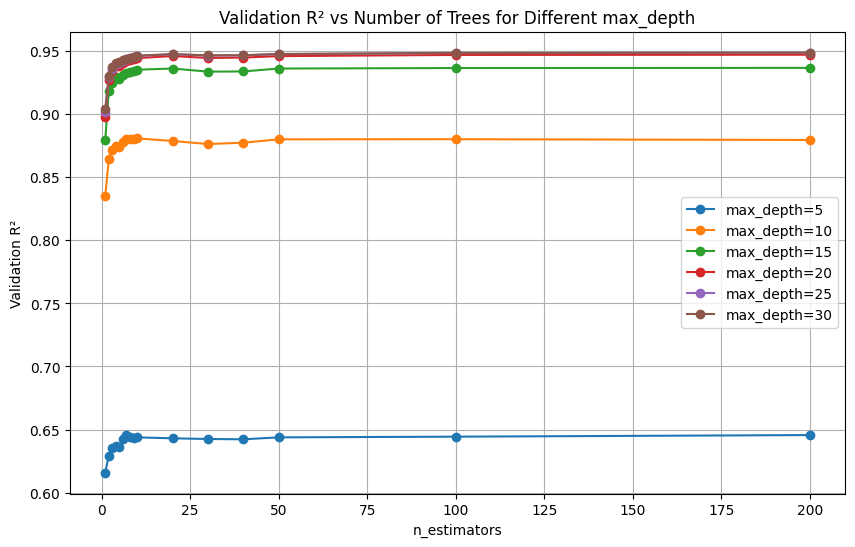

In [16]:
plt.figure(figsize=(10,6))

for depth in sorted(df_scores['max_depth'].unique()):
    subset = df_scores[df_scores['max_depth'] == depth]
    plt.plot(subset['n_estimators'], subset['r2_val'], marker='o', label=f'max_depth={depth}')

plt.xlabel('n_estimators')
plt.ylabel('Validation R²')
plt.title('Validation R² vs Number of Trees for Different max_depth')
plt.legend()
plt.grid(True)
plt.show()

**Insights:**

R2 corresponding to n_estimators peaks at 20, and stays the same thereafter.<br>
Therefore, the best is `n_estimators=20`

#### Overfitting Estimation (max_depth)

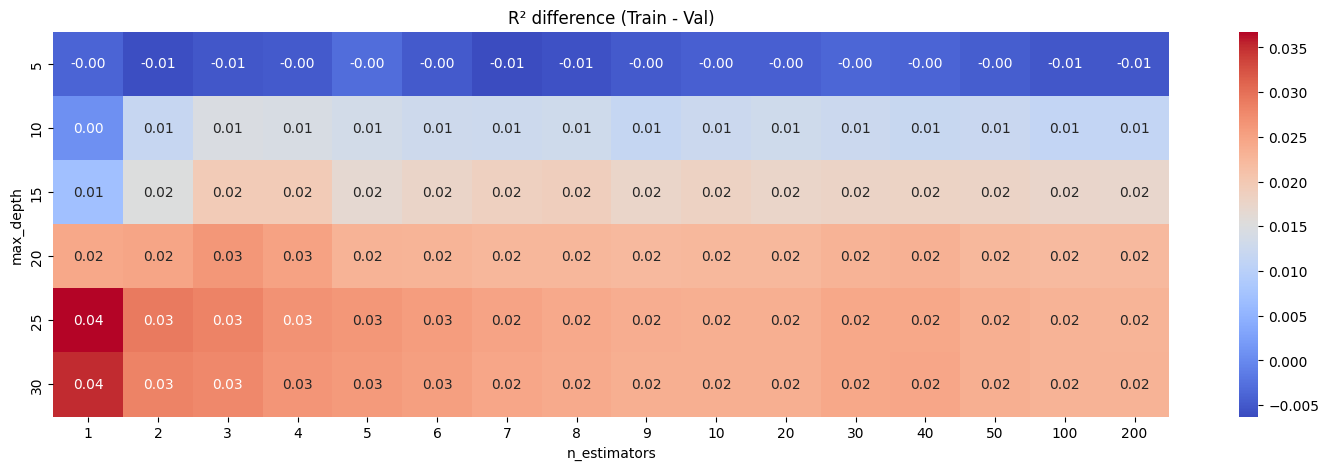

In [17]:
# Overfitting Estimation

pivot_val = df_scores.pivot(index='max_depth', columns='n_estimators', values='r2_val')
pivot_train = df_scores.pivot(index='max_depth', columns='n_estimators', values='r2_train')
pivot_diff = df_scores.pivot(index='max_depth', columns='n_estimators', values='r2_diff')

plt.figure(figsize=(18,5))

sns.heatmap(pivot_diff, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("R² difference (Train - Val)")

plt.show()

**Insights** : 

Since the difference in R2 between train and validation datasets are very small (max: 0.03), the `overfitting is negligible`

### Choosing the best `min_samples_leaf` value

In [18]:
min_leaf = [1,2,3,4,5,10,15,30,50]

scores = [] 
max_depth = 20 
n_estimators = 20

for s in min_leaf:
    dv, rf = rf_train(df_train, y_train_log, 
                      n_estimators=n_estimators, max_depth=max_depth, 
                      min_samples_leaf=s)
    
    # Predict on validation set
    y_pred_val_log = rf_predict(df_val, dv, rf)
    y_pred_val = np.expm1(y_pred_val_log)  # convert back to original units
    
    # Predict on test set
    y_pred_test_log = rf_predict(df_test, dv, rf)
    y_pred_test = np.expm1(y_pred_test_log)

    # Predict on train set - only to measure against val set. 
    y_pred_train_log = rf_predict(df_train, dv, rf)
    y_pred_train = np.expm1(y_pred_train_log)
    
    # Evaluate metrics on val
    rmse, mae, r2_val = regression_metrics(y_val, y_pred_val)
    
    r2_train = r2_score(y_train, y_pred_train)
    
    scores.append((s,rmse,mae,r2_val,r2_train))

In [19]:
columns = ['min_samples_leaf', 'rmse', 'mae', 'r2_val', 'r2_train']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores['r2_diff'] = df_scores['r2_train'] - df_scores['r2_val']


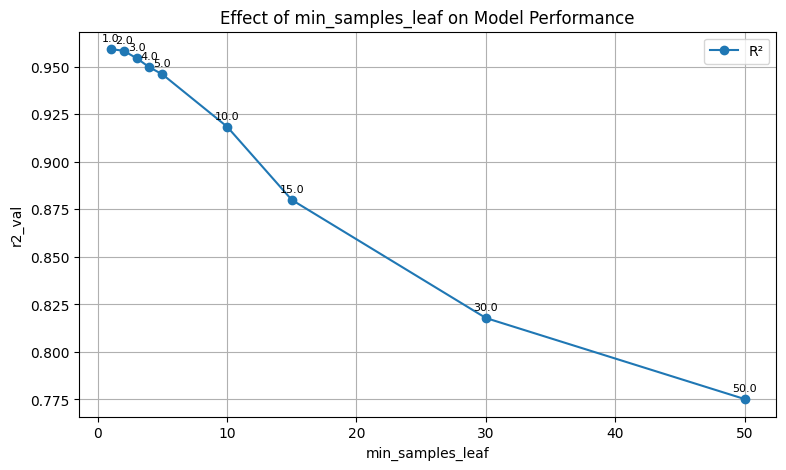

In [20]:
plt.figure(figsize=(9,5))
plt.plot(df_scores['min_samples_leaf'], df_scores['r2_val'], marker='o', label='R²')

for i, row in df_scores.iterrows():
    plt.text(row['min_samples_leaf'], row['r2_val']+0.003, 
             str(row['min_samples_leaf']), 
             fontsize=8, ha='center', va='bottom')

plt.xlabel('min_samples_leaf')
plt.ylabel('r2_val')
plt.title('Effect of min_samples_leaf on Model Performance')
plt.legend()
plt.grid(True)
plt.show()


**Insights:**

Based on the chart above, we can see that min_samples_leaf values of 1,2,3,4 give us the highest R2 <br>
But to prevent the model from memorizing the patterm, we can choose `min_samples_leaf=3/4`. 

#### Overfitting Estimation (min_samples_leaf)

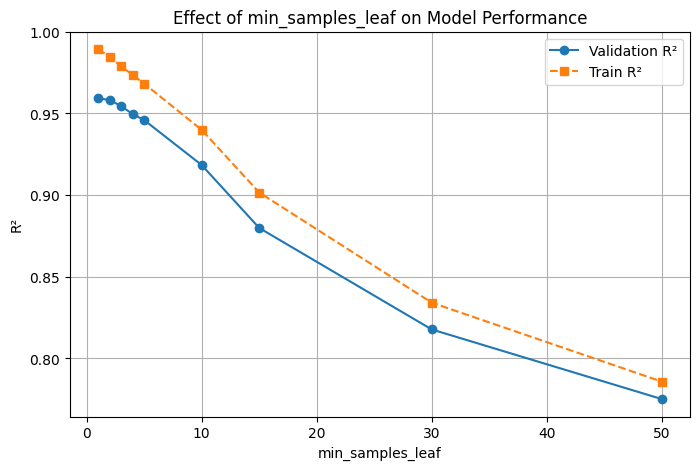

In [21]:
plt.figure(figsize=(8,5))
plt.plot(df_scores['min_samples_leaf'], df_scores['r2_val'], marker='o', label='Validation R²')
plt.plot(df_scores['min_samples_leaf'], df_scores['r2_train'], marker='s', linestyle='--', label='Train R²')
plt.xlabel('min_samples_leaf')
plt.ylabel('R²')
plt.title('Effect of min_samples_leaf on Model Performance')
plt.legend()
plt.grid(True)
plt.show()



**Insights:**

Since there is not much between train and validation R2,  overfitting is not a problem. 

## Results

In [36]:
max_depth = 20 
n_estimators = 20
min_samples_leaf = 3

dv, rf = rf_train(df_train, y_train_log, 
                      n_estimators=n_estimators, max_depth=max_depth, 
                      min_samples_leaf=min_samples_leaf)
    
# Predict on validation set
y_pred_val_log = rf_predict(df_val, dv, rf)
y_pred_val = np.expm1(y_pred_val_log)  # convert back to original units
    
# Evaluate metrics on val
rmse, mae, r2_val = regression_metrics(y_val, y_pred_val)
    
print(f"Validation RMSE:{rmse}")
print(f"Validation MAE:{mae}")
print(f"Validation R2:{r2_val}")
        


Validation RMSE:17272.68116283582
Validation MAE:8739.524476603994
Validation R2:0.9544206645500115
